<a href="https://colab.research.google.com/github/ArtemChemist/CFU_counter/blob/main/EffNetB0_5reps_custom_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Unins

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time
import cv2

from keras.models import Model, Sequential
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop


import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.applications import EfficientNetB0


2.9.1


In [3]:
# Parameters of the images
SIZE = 224 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

#Parameterf of the CNN
Filters = 16
BATCH_SIZE = 32
EPOCHS = 100
num_classes = 2  # Number of clases for prediction

#Parameters of the test-val split
TEST_SIZE = 0.3   # Validation/Train split ratio
RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Import custom module with helper functions
import sys
sys.path.append('/content/drive/My Drive')
import funcs as f

# Unzip archives with images
!unzip -q "/content/drive/My Drive/224_nothresh.zip" -d "/content"
!unzip -q "/content/drive/My Drive/224.zip" -d "/content"

Mounted at /content/drive


In [5]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
input_dir = os.path.join(p, f'{SIZE}_nothresh')

X_files , y = f.read_names(input_dir)
print(f'Full dataset: {np.sum(y)} images with bacteria and {len(y)-np.sum(y)} without')

Full dataset: 300 images with bacteria and 3479 without


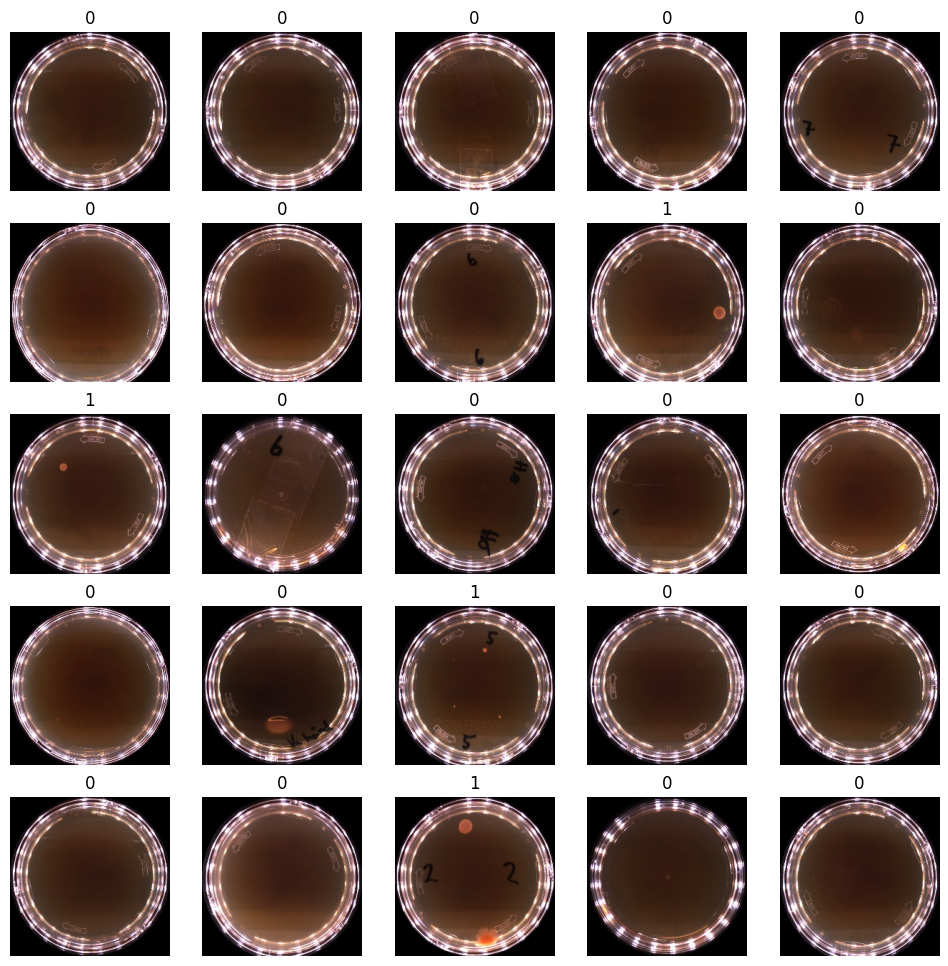

In [6]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    file = os.path.join(input_dir, X_files[idx])
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y[idx])
    axs[i,j].axis('off')

plt.show()

In [7]:
def build_model(num_classes):
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=1),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)

    inputs = Input(shape=INPUT_SHAPE)
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)
    x = Dense(1024, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

early_stopping = f.CustomStopper()

In [9]:
for iter in range (5):
  print (f"Start iteration {iter}")
  # Get the names of the files that will be used for both thresholded and non-thresholded images
  X_train_names, X_val_names, y_train, y_val = f.custom_train_val_split(X_files, y, TEST_SIZE, RAND_SEED+iter)

  # Read the actual files
  print("Reading images...")
  no_thr_dir = os.path.join(p, f'{SIZE}_nothresh')   #Set the folder where nonthreholded files live
  X_train, y_train = f.read_aug_images(X_train_names, no_thr_dir)
  X_val = f.read_images(X_val_names, no_thr_dir)

  # Create a TensorFlow Dataset
  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

  #Define the model
  model = build_model(2)

  # Train the model with the early stopping callback
  print("Training model...")
  start_time = time.time()
  history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
  end_time = time.time()
  print(f"Training took {end_time - start_time:.2f} seconds")

  # Save results
  model_dir = os.path.join(p, "drive", "MyDrive", 'B0_custaug', f'{iter}_custaug_model')
  result_dir = os.path.join(p, "drive", "MyDrive", 'B0_custaug')
  y_true = np.argmax(y_val, axis=1)
  y_pred = model.predict(X_val)
  thresholds = np.arange(0, 0.055, 0.0005)

  f.save_model_results(model, model_dir, X_val_names, 0.0005, y_true, y_pred, thresholds, history, result_dir, f'B0224_cust_aug_{iter}')


Start iteration 0
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 224_nothresh... Before augmentation: 210 images with bacteria and 2436 without
Suffling dataset ....
Data set shape (7266, 224, 224, 3); labeles shape (7266,)
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 224_nothresh... 

Done


16705208/16705208 [==============================] - 0s 0us/step
Training model...
Epoch 1/100
228/228 - 91s - loss: 0.2279 - accuracy: 0.9360 - val_loss: 0.1441 - val_accuracy: 0.9700 - 91s/epoch - 398ms/step
Epoch 2/100
228/228 - 82s - loss: 0.1055 - accuracy: 0.9623 - val_loss: 0.0917 - val_accuracy: 0.9771 - 82s/epoch - 360ms/step
Epoch 3/100
228/228 - 84s - loss: 0.0776 - accuracy: 0.9723 - val_loss: 0.0941 - val_accuracy: 0.9779 - 84s/epoch - 367ms/step
Epoch 4/100
228/228 - 82s - loss: 0.0755 - accuracy: 0.9761 - val_loss: 0.0906 - val_accuracy: 0.9762 - 82s/epoch - 360ms/step
Epoch 5/100
228/228 - 81s - loss: 0.0692 - accuracy: 0.9776 - val_loss: 0.1099 - val_accuracy: 0.9753 - 81s/epoch - 355ms/step
Epoch 6/100
228/228 - 82s - loss: 0.0759 - accuracy: 0.9759 - val_loss: 0.1158 - val_accuracy: 0.9771 - 82s/epoch - 360ms/step
Epoch 7/100
228/228 - 85s - loss: 0.0568 - accuracy: 0.9811 - val_loss: 0.0949 - val_accuracy: 0.9771 - 85s/epoch - 373ms/step
Epoch 8/100
228/228 - 86s - 

Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Start iteration 1
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 224_nothresh... Before augmentation: 210 images with bacteria and 2436 without
Suffling dataset ....
Data set shape (7266, 224, 224, 3); labeles shape (7266,)
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 224_nothresh... Done
Training model...
Epoch 1/100
228/228 - 89s - loss: 0.2078 - accuracy: 0.9388 - val_loss: 0.1249 - val_accuracy: 0.9647 - 89s/epoch - 391ms/step
Epoch 2/100
228/228 - 140s - loss: 0.1111 - accuracy: 0.9624 - val_loss: 0.0933 - val_accuracy: 0.9700 - 140s/epoch - 614ms/step
Epoch 3/100
228/228 - 116s - loss: 0.0829 - accuracy: 0.9721 - val_loss: 0.

Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Start iteration 2
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 224_nothresh... Before augmentation: 210 images with bacteria and 2436 without
Suffling dataset ....
Data set shape (7266, 224, 224, 3); labeles shape (7266,)
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 224_nothresh... Done
Training model...
Epoch 1/100
228/228 - 87s - loss: 0.2279 - accuracy: 0.9341 - val_loss: 0.2537 - val_accuracy: 0.9285 - 87s/epoch - 381ms/step
Epoch 2/100
228/228 - 78s - loss: 0.1157 - accuracy: 0.9612 - val_loss: 0.1403 - val_accuracy: 0.9656 - 78s/epoch - 344ms/step
Epoch 3/100
228/228 - 80s - loss: 0.0787 - accuracy: 0.9700 - val_loss: 0.162

Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Start iteration 3
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 224_nothresh... Before augmentation: 210 images with bacteria and 2436 without
Suffling dataset ....
Data set shape (7266, 224, 224, 3); labeles shape (7266,)
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 224_nothresh... Done
Training model...
Epoch 1/100
228/228 - 93s - loss: 0.2169 - accuracy: 0.9382 - val_loss: 0.1748 - val_accuracy: 0.9470 - 93s/epoch - 407ms/step
Epoch 2/100
228/228 - 85s - loss: 0.1162 - accuracy: 0.9612 - val_loss: 0.1154 - val_accuracy: 0.9603 - 85s/epoch - 372ms/step
Epoch 3/100
228/228 - 83s - loss: 0.0866 - accuracy: 0.9693 - val_loss: 0.132

Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
Start iteration 4
Full dataset: 300 images with bacteria and 3479 without
Shuffling validation dataset ....
(1133,) - (1133,)
Shuffling trainig dataset ....
Validation X: (1133,); y: (1133, 2)
Training X: (2646,); y: (2646, 2)
Reading images...
Reading and agumenting 2646 images from 224_nothresh... Before augmentation: 210 images with bacteria and 2436 without
Suffling dataset ....
Data set shape (7266, 224, 224, 3); labeles shape (7266,)
After augmentation: 4830 images with bacteria and 2436 without
Reading 1133 images from 224_nothresh... Done
Training model...
Epoch 1/100
228/228 - 90s - loss: 0.2252 - accuracy: 0.9346 - val_loss: 0.3407 - val_accuracy: 0.8870 - 90s/epoch - 393ms/step
Epoch 2/100
228/228 - 82s - loss: 0.1015 - accuracy: 0.9648 - val_loss: 0.1961 - val_accuracy: 0.9276 - 82s/epoch - 360ms/step
Epoch 3/100
228/228 - 93s - loss: 0.0741 - accuracy: 0.9732 - val_loss: 0.185

Saving precision-recall data...
Saving training history...
Saving names of mispredicted images...
